In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np

# Predicting Car Market Price
Data set available from: https://archive.ics.uci.edu/ml/datasets/automobile

In [9]:
cols = ['symboling','normalized-losses','make','fuel-type','aspiration',
'num-of-doors','body-style','drive-wheels','engine-location','wheel-base',
'length','width','height','curb-weight','engine-type','num-of-cylinders',
'engine-size','fuel-system','bore','stroke','compression-ratio','horsepower',
'peak-rpm','city-mpg','highway-mpg','price']

cars = pd.read_csv('../data/imports-85.data', names=cols)
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


# Data Cleaning

### Data types
There is a mix of numerical and catagorical data types.  
There are no null cells between the 205 entries of 26 columns

In [10]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-nul

### Inspect the values for each column
It seems like '?' has been used in place of N/A.  
Theses value will need to be cleaned

In [11]:
# for col in cars.columns:
#     print(cars[col].value_counts())
#     print('-----------')
cars['normalized-losses'].value_counts().head()

?      41
161    11
91      8
150     7
104     6
Name: normalized-losses, dtype: int64

### Columns that contain a '?' 
They will need to replaced with N/A.  

In [12]:
# check to see how many "?" each column contains
question = (cars == '?').sum()
missing_data = question[question > 0]
missing_cols = missing_data.index.tolist()
print('Number of "?" before replacement:')
print(missing_data)

# replace "?" with np.nan
cars.replace('?',np.nan, inplace=True)

Number of "?" before replacement:
normalized-losses    41
num-of-doors          2
bore                  4
stroke                4
horsepower            2
peak-rpm              2
price                 4
dtype: int64


C:\Users\Jameshuckle\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


### Drop N/A's
Columns with more than 10% N/A's can be dropped.  
Rows with further N/A's can be dropped.

In [13]:
# drop columns with more than 10% NA's
cars.dropna(axis='columns', thresh=int(len(cars)*0.9), inplace=True)
cars.dropna(axis='rows',inplace=True)
nans = cars.isnull().sum().sum()
print("total number of N/A's:",nans)

total number of N/A's: 0


### Convert text numbers into numerical type

In [14]:
text_num_cols = ['num-of-doors','num-of-cylinders']
nums = {'two':2, 'three':3, 'four':4, 'five':5, 'six':6, 'eight':8, 'twelve':12}
for col in text_num_cols:
    cars[col] = cars[col].map(nums)
    
# convert all columns to numerical type is possble
for col in cars.columns:
    cars[col] = pd.to_numeric(cars[col], errors='ignore')

### Normalise features (rescaling between 0-1)
Drop any non numerical column

In [15]:
num_cols = cars.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('price')
price = cars['price'].copy()
cars = cars[num_cols]
cars = cars / cars.max()
cars = cars.abs()
cars['price'] = price

# Data Exploration

Features that have a strong correlation performed well in K nearest neighbors algorithm

In [16]:
cars.corr()['price'].abs().sort_values(ascending=False)

price                1.000000
engine-size          0.888778
curb-weight          0.835368
horsepower           0.812453
width                0.754649
num-of-cylinders     0.746007
highway-mpg          0.719178
city-mpg             0.706618
length               0.695928
wheel-base           0.584951
bore                 0.546295
height               0.136234
peak-rpm             0.103835
stroke               0.096007
compression-ratio    0.074483
num-of-doors         0.046460
symboling            0.029431
Name: price, dtype: float64

### Train KNN model

Create a train test split  
Do a univariate test with a selection of n neighbors to see which features perform best

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def knn_train_test(data, feature_cols, target_col, k):
    train, test = train_test_split(data, test_size=0.5, random_state=42)
    train_x = train[feature_cols]
    train_y = train[target_col]
    test_x = test[feature_cols]
    test_y = test[target_col]
    
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_x, train_y)
    predictions = knn.predict(test_x)
    mse = mean_squared_error(predictions, test_y)
    rmse = mse ** 0.5
    return rmse

In [18]:
def univariate_with_n_values():
    results_col = {}
    for col in cars.columns:
        if col == 'price': continue
        results_n = {}
        for n in [1,3,5,7,9]:
            rmse = knn_train_test(cars, [col], 'price', n)
            results_n[n] = rmse
        results_col[col] = results_n
    return results_col

results_col = univariate_with_n_values()

### Results
7 n_neighbors performed the best on average.  
The most predictive features were engine size, city mpg and horsepower

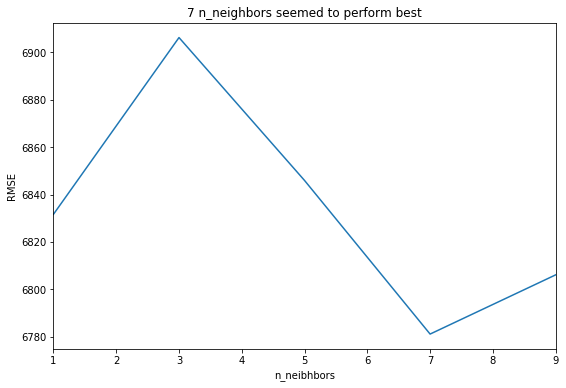

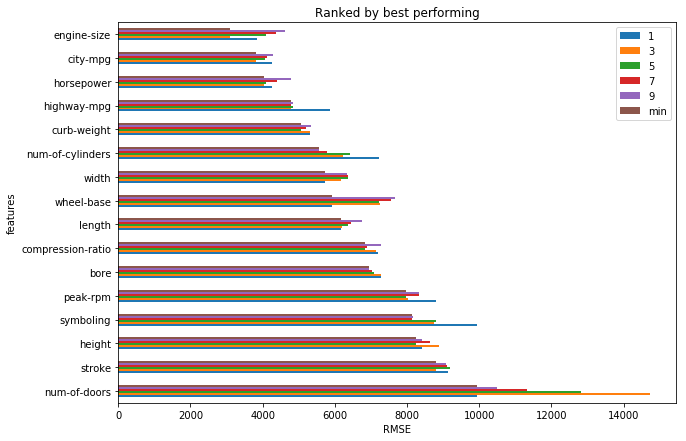

In [19]:
knn_results = pd.DataFrame(results_col).transpose()
ax = knn_results.mean(axis='rows').plot(x=knn_results.index, figsize=(9,6),
                                   title='7 n_neighbors seemed to perform best')
ax.set_xlabel("n_neibhbors")
ax.set_ylabel("RMSE")
knn_results['min'] = knn_results.min(axis='columns')
knn_results.sort_values('min', inplace=True, ascending=False)
ax = knn_results.plot.barh(figsize=(10,7), title='Ranked by best performing')
ax.set_xlabel("RMSE")
ax.set_ylabel("features")
best_features = list(knn_results.index[-5:])[::-1]

### Feature selection and hyper parameter tuning
Test the best 2,3,4,5 features using KNN with 1-24 n_neighbors hyperparameter to see which provides the lowest RMSE

In [20]:
best_features

['engine-size', 'city-mpg', 'horsepower', 'highway-mpg', 'curb-weight']

In [21]:
def best_features_and_k():
    results_features = {}
    for idx in range(2,len(best_features)+1):
        cols = best_features[0:idx]
        print(cols)
        results_k = {}
        for k in range(1,25):
            rmse = knn_train_test(cars, cols, 'price', k)
            results_k[k] = rmse
        results_features["top_" + str(idx) + "_features"] = results_k
    return results_features

results_features = best_features_and_k()

['engine-size', 'city-mpg']
['engine-size', 'city-mpg', 'horsepower']
['engine-size', 'city-mpg', 'horsepower', 'highway-mpg']
['engine-size', 'city-mpg', 'horsepower', 'highway-mpg', 'curb-weight']


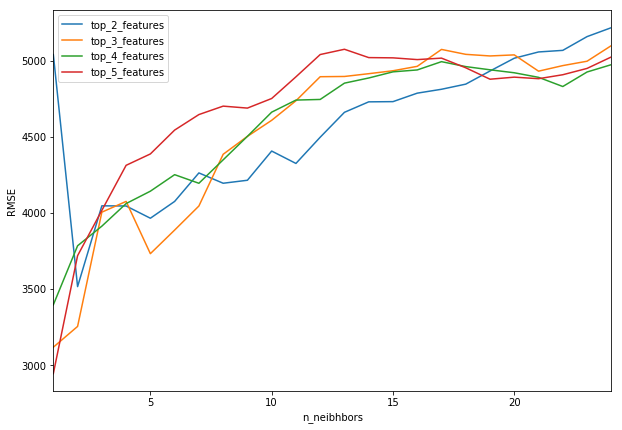

,n_neighbors,variable,rmse
72,1,top_5_features,2945.200681
24,1,top_3_features,3118.513325
25,2,top_3_features,3254.921884
48,1,top_4_features,3396.796139
1,2,top_2_features,3516.341259


In [22]:
# plot the results
knn_final_results = pd.DataFrame(results_features)
ax = knn_final_results.plot(figsize=(10,7))
ax.set_xlabel("n_neibhbors")
ax.set_ylabel("RMSE")
plt.show()

# view the top 5 best performing 
knn_final_results.reset_index(inplace=True)
knn_final_results.rename(mapper={'index':'n_neighbors'}, axis='columns',inplace=True)
top_results = pd.melt(knn_final_results,id_vars=['n_neighbors'])
top_results.rename(mapper={'value':'rmse'}, axis='columns',inplace=True)
top_results.sort_values('rmse').head()

### Conclusion
Best features: engine-size, city-mpg, horsepower, highway-mpg and curb-weight  
Optimum n_neighbors: 1  
RMSE: 0.064872

### Train on all data
### Make a prediction

In [23]:
features = ['engine-size', 'city-mpg', 'horsepower', 'highway-mpg', 'curb-weight']
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(cars[features], cars['price'])

my_car = {'engine-size':160, 'city-mpg':65, 'horsepower':120, 'highway-mpg':50, 'curb-weight':1100}
my_car = pd.DataFrame([my_car])
prediction = knn.predict(my_car)[0]
print(f"My Seat Ibiza is worth ${prediction}")

My Seat Ibiza is worth $6479.0
